In [1]:
import sys
import time

if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")

In [85]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import ConfusionMatrixDisplay
# import seaborn as sns
# sns.set()
from sklearn import tree
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PowerTransformer
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn import svm
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
import seaborn as sns


In [86]:
filenames = {
    "emulab_hdd_merged": "emulab_d460_10Gbps_hdd_merged_V2.csv",
    "emulab_hdd_unmerged": "emulab_d460_10Gbps_hdd_unmerged_V2.csv",

    "utah_ssd_merged": "utah_c6525-25g_25Gbps_ssd_merged_V2.csv",
    "utah_ssd_unmerged": "utah_c6525-25g_25Gbps_ssd_unmerged_V2.csv",

    "wisconsin_ssd_merged": "wisconsin_c220g1-10Gbps_ssd_merged_V2.csv",
    "wisconsin_ssd_unmerged": "wisconsin_c220g1-10Gbps_ssd_unmerged_V2.csv",

    "utah_ssd_merged_1g": "utah_c6525-25g_1Gbps_ssd_merged_V2.csv",
    "utah_ssd_unmerged_1g": "utah_c6525-25g_1Gbps_ssd_unmerged_V2.csv",

    "wisconsin_hdd_ssd_merged": "wisconsin_c220g1-10Gbps_hdd_ssd_merged_V2.csv",
    "wisconsin_hdd-ssd_unmerged": "wisconsin_c220g1-10Gbps_hdd_ssd_unmerged_V2.csv",
}


In [ ]:
def model_factory(model_name):
    if model_name == "RandomForest":
        return RandomForestClassifier(n_estimators=100)
    elif model_name == "DecisionTreeClassifier":
        return DecisionTreeClassifier()
    elif model_name == "SVM":
        return  svm.SVC()
    elif model_name == "MLPNeuralNetwork":
        return MLPClassifier()
    elif model_name == "XGB":
        return XGBClassifier()
    else:
        return RandomForestClassifier(n_estimators=100)

In [231]:
emulab_hdd_merged = pd.read_csv(filenames.get('emulab_hdd_merged')).drop(['time_stamp', 'through_put'], axis=1)

utah_ssd_merged = pd.read_csv(filenames.get('wisconsin_ssd_unmerged')).drop(['time_stamp', 'through_put'], axis=1)


In [232]:
df = utah_ssd_merged
# np.round((sum(sum((df == 0).values))) / (len(df) * len(df.columns)),3)
df.shape

(24208, 117)

In [213]:
# df
len(dict(Counter(df[df.columns[len(df.columns) - 1]])))

161

In [87]:
y = df.label_value
X = df.drop(columns="label_value") # df[features]
X_train, X_test, y_train, y_test = train_test_split(X,y)
print(X_train.shape)
X_train, y_train = RandomUnderSampler(sampling_strategy="all").fit_resample(X_train, y_train)
print(X_train.shape)
clf = RandomForestClassifier(n_estimators=100)

clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(np.round(metrics.accuracy_score(y_test, y_pred) * 100, 2))
# print(metrics.confusion_matrix(y_test, y_pred))
score = np.round(clf.feature_importances_, 2)

# print(sorted(list(score), reverse=True))
print("Cummulative Importance Score: \n", np.cumsum(sorted(list(score), reverse=True)))
print(Counter(score))

(18156, 116)
(2310, 116)
97.95
Cummulative Importance Score: 
 [0.05 0.09 0.13 0.17 0.21 0.25 0.28 0.31 0.34 0.37 0.4  0.43 0.45 0.47
 0.49 0.51 0.53 0.55 0.57 0.59 0.61 0.63 0.65 0.67 0.69 0.71 0.73 0.75
 0.76 0.77 0.78 0.79 0.8  0.81 0.82 0.83 0.84 0.85 0.86 0.87 0.88 0.89
 0.9  0.91 0.92 0.93 0.94 0.95 0.96 0.96 0.96 0.96 0.96 0.96 0.96 0.96
 0.96 0.96 0.96 0.96 0.96 0.96 0.96 0.96 0.96 0.96 0.96 0.96 0.96 0.96
 0.96 0.96 0.96 0.96 0.96 0.96 0.96 0.96 0.96 0.96 0.96 0.96 0.96 0.96
 0.96 0.96 0.96 0.96 0.96 0.96 0.96 0.96 0.96 0.96 0.96 0.96 0.96 0.96
 0.96 0.96 0.96 0.96 0.96 0.96 0.96 0.96 0.96 0.96 0.96 0.96 0.96 0.96
 0.96 0.96 0.96 0.96]
Counter({0.0: 67, 0.01: 21, 0.02: 16, 0.03: 6, 0.04: 5, 0.05: 1})


In [88]:
features = []
for i in range(len(score)):
    if score[i] >= 0.02:
        features.append(X.columns[i])
        # print(df.columns[i])
print(features)
print(len(features))


['sender_avg_rtt_value', 'sender_cwnd_rate', 'sender_seg_out', 'sender_retrans', 'sender_ssthresh_value', 'sender_segs_in', 'sender_avg_send_value', 'sender_tcp_snd_buffer_min', 'sender_tcp_snd_buffer_max', 'sender_req_waittime', 'sender_req_active', 'sender_read_bytes', 'sender_ost_read', 'sender_ost_write', 'sender_avg_waittime_md', 'sender_system_cpu_percent', 'sender_remote_ost_read_bytes', 'sender_remote_ost_write_bytes', 'receiver_seg_out', 'receiver_segs_in', 'receiver_req_waittime', 'receiver_req_active', 'receiver_write_bytes', 'receiver_ost_write', 'receiver_avg_waittime_md', 'receiver_system_cpu_percent', 'receiver_remote_ost_read_bytes', 'receiver_remote_ost_write_bytes']
28


In [89]:
features = ['sender_avg_rtt_value', 'sender_cwnd_rate', 'sender_retrans', 'sender_ssthresh_value', 'sender_segs_in', 'sender_avg_send_value', 'sender_tcp_snd_buffer_min', 'sender_tcp_snd_buffer_max', 'sender_req_active', 'sender_write_bytes', 'sender_avg_waittime_md', 'sender_system_cpu_percent', 'sender_remote_ost_write_bytes', 'receiver_seg_out', 'receiver_segs_in', 'receiver_req_waittime', 'receiver_req_active', 'receiver_write_bytes', 'receiver_ost_write', 'receiver_avg_waittime_md', 'receiver_system_cpu_percent', 'receiver_system_memory_percent', 'receiver_remote_ost_read_bytes', 'receiver_remote_ost_write_bytes']

In [20]:
y_new = df.label_value
X_new = df[features] #.drop(columns="label_value")
X_train, X_test, y_train, y_test = train_test_split(X_new,y_new)
print(X_train.shape)
X_train, y_train = RandomUnderSampler(sampling_strategy="all").fit_resample(X_train, y_train)
print(X_train.shape)
clf_new = RandomForestClassifier(n_estimators=100)
# clf = make_pipeline(StandardScaler(), SVC())
# clf = SVC()
clf_new.fit(X_train, y_train)
y_pred = clf_new.predict(X_test)
print(np.round(metrics.accuracy_score(y_test, y_pred) * 100, 2))

(30984, 24)
(3948, 24)
95.67


In [90]:
def update_labels_xgboost(df):
    updated_labels = {0:0, 1:1, 10:2, 19:3, 28:4, 37:5,
                      46:6, 55:7, 64:8, 73:9, 82:10, 91:11,
                      100:12, 109:13, 113:14, 117:15, 129:16,
                      133:17, 145:18, 151:19, 157:20}
    y = [updated_labels[int(i)] for i in df[df.columns[len(df.columns) - 1]].values]
    df["label_value"] = y
    return df

## TEST WITH DIFFERENT CLASSIFIRES MEREGD LEVELS - 21 labels

In [177]:
datasets = ['emulab_hdd_merged', 'utah_ssd_merged', 'wisconsin_ssd_merged', 'utah_ssd_merged_1g', 'wisconsin_hdd_ssd_merged']
classifiers = {"RandomForest": RandomForestClassifier(n_estimators=100),
           "DecisionTreeClassifier": DecisionTreeClassifier(),
           "SVM": svm.SVC(),
           "MLPNeuralNetwork": MLPClassifier(),
           "XGB": XGBClassifier(),
        }
classifiers_legends = list(classifiers.keys())
all_accuracies = {}
round_number = 1
training_time = {}
import time
for clf_key in classifiers:
    accuracies = np.zeros(len(datasets))
    for i in range(round_number):
        temp_acc = np.array([])
        for key in datasets:
            print("run {} model for dataset: {}".format(clf_key.replace("\n", " "), key))
            df = pd.read_csv(filenames.get(key)).drop(['time_stamp', 'through_put'], axis=1)
            if clf_key == "XGB":
                df = update_labels_xgboost(df)
            y = df.label_value
            X = df.drop(columns="label_value")[features] # df[features]
            X_train, X_test, y_train, y_test = train_test_split(X,y)
            # print(X_train.shape)
            X_train, y_train = RandomUnderSampler(sampling_strategy="all").fit_resample(X_train, y_train)
            # print(X_train.shape)
            # clf = classifiers[clf_key]
            clf = model_factory(clf_key)
            clf = make_pipeline(StandardScaler(), clf)
            time_1 = time.time()
            clf.fit(X_train, y_train)
            time_2 = time.time()
            if training_time.get(clf_key):
                training_time.get(clf_key).append(time_2-time_1)
            else:
                training_time[clf_key] = [time_2-time_1]
            y_pred = clf.predict(X_test)
            accuracy = np.round(metrics.accuracy_score(y_test, y_pred) * 100, 2)
            temp_acc = np.append(temp_acc, accuracy)
        accuracies = np.add(accuracies, temp_acc)
    print("\n")
    accuracies = accuracies / round_number
    all_accuracies[clf_key] = accuracies

print(classifiers_legends)
print(datasets)
print(all_accuracies)
print(training_time)

run RandomForest model for dataset: emulab_hdd_merged
run RandomForest model for dataset: utah_ssd_merged
run RandomForest model for dataset: wisconsin_ssd_merged
run RandomForest model for dataset: utah_ssd_merged_1g
run RandomForest model for dataset: wisconsin_hdd_ssd_merged


run DecisionTreeClassifier model for dataset: emulab_hdd_merged
run DecisionTreeClassifier model for dataset: utah_ssd_merged
run DecisionTreeClassifier model for dataset: wisconsin_ssd_merged
run DecisionTreeClassifier model for dataset: utah_ssd_merged_1g
run DecisionTreeClassifier model for dataset: wisconsin_hdd_ssd_merged


run SVM model for dataset: emulab_hdd_merged
run SVM model for dataset: utah_ssd_merged
run SVM model for dataset: wisconsin_ssd_merged
run SVM model for dataset: utah_ssd_merged_1g
run SVM model for dataset: wisconsin_hdd_ssd_merged


run MLPNeuralNetwork model for dataset: emulab_hdd_merged
run MLPNeuralNetwork model for dataset: utah_ssd_merged
run MLPNeuralNetwork model for dataset

In [194]:
_21_labels_accs = all_accuracies
# {'RandomForest': array([95.614, 98.944, 97.074, 98.776, 97.536]), 'DecisionTreeClassifier': array([93.648, 97.23 , 94.22 , 98.36 , 96.126]), 'SVM': array([85.86 , 94.902, 93.404, 90.852, 94.856]), 'MLPNeuralNetwork': array([91.064, 97.82 , 95.668, 95.564, 97.388]), 'XGB': array([98.344, 98.768, 97.522, 99.07 , 98.042])}
all_accuracies = {'RandomForest': np.array([95.68, 99.12, 97.39, 98.81, 96.98]), 'DecisionTreeClassifier': np.array([93.38, 97.37, 94.46, 97.6 , 95.75]), 'SVM': np.array([85.89, 95.33, 93.42, 90.31, 94.56]), 'MLPNeuralNetwork': np.array([91.45, 98.17, 95.62, 95.07, 97.75]), 'XGB': np.array([97.92, 98.83, 97.64, 99.33, 97.79])}

In [199]:
# np.average([95.68, 99.12, 97.39, 98.81, 96.98])
np.average([97.92, 98.83, 97.64, 99.33, 97.79])

97.596

In [181]:
print(np.average([0.7868380546569824, 0.417910099029541, 0.35545897483825684, 0.34842419624328613, 0.354356050491333]))
print(np.average([2.951751232147217, 1.601038932800293, 1.7936930656433105, 1.8401007652282715, 1.371891975402832]))

0.45259747505187986
1.9116951942443847


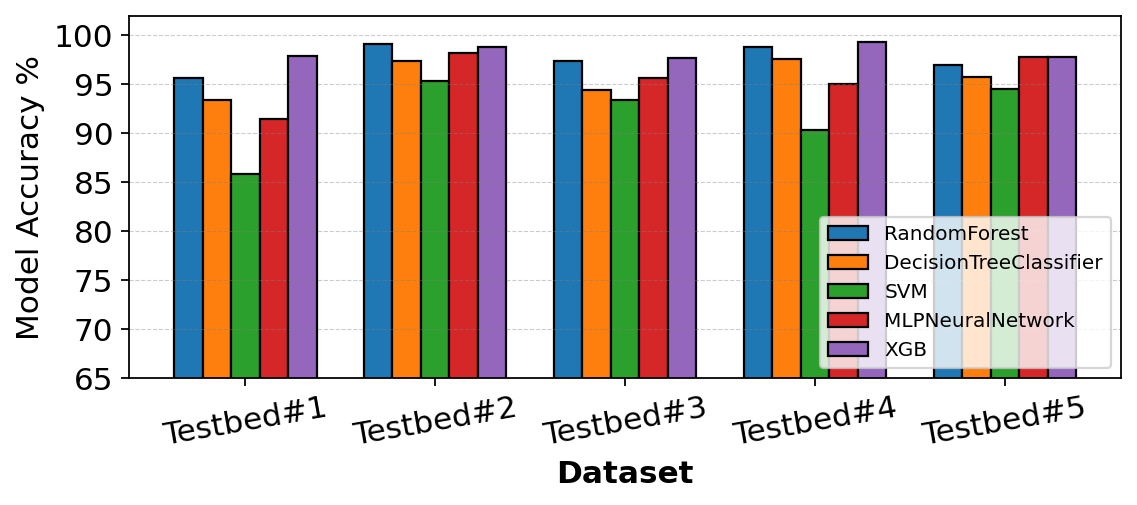

In [195]:
plt.rcParams.update({'font.size': 14})
# Figure Size
fig, ax = plt.subplots(figsize =(8, 3), dpi=160)
barWidth = 0.15

# Set position of bar on X axis
br1 = np.arange(len(datasets))
br2 = [x + barWidth for x in br1]
br3 = [x + barWidth for x in br2]
br4 = [x + barWidth for x in br3]
br5 = [x + barWidth for x in br4]

ax.grid(visible = True, axis='y', color ='grey', linestyle ='--', linewidth = 0.5, alpha = 0.4)
ax.set_ylabel('Model Accuracy %')
ax.set_ylim(ymin=65, ymax=102)


ax.bar(br1, all_accuracies['RandomForest'], width = barWidth, edgecolor ='black', label="RandomForest")
ax.bar(br2, all_accuracies['DecisionTreeClassifier'], width = barWidth, edgecolor ='black', label="DecisionTreeClassifier",)
ax.bar(br3, all_accuracies['SVM'], width = barWidth, edgecolor ='black', label="SVM", )
ax.bar(br4, all_accuracies['MLPNeuralNetwork'], width = barWidth, edgecolor ='black', label="MLPNeuralNetwork")
ax.bar(br5, all_accuracies['XGB'], width = barWidth, edgecolor ='black', label="XGB")


plt.xlabel('Dataset', fontweight ='bold')
plt.yticks(np.arange(65, 101, 5))
xticks = ['Testbed#1', 'Testbed#2', 'Testbed#3', 'Testbed#4', 'Testbed#5']
plt.xticks([r + 0.3 for r in range(len(br1))], xticks, rotation=10)

plt.legend(fontsize = 9, loc='lower right')
plt.savefig("21_labels_accuracies.pdf", bbox_inches='tight')

## TEST WITH DIFFERENT CLASSIFIRES UNMERGED LEVELS - 161 labels

In [95]:
df = pd.read_csv(filenames.get('emulab_hdd_unmerged')).drop(['time_stamp', 'through_put'], axis=1)
df.shape
print(len(dict(Counter(df[df.columns[len(df.columns) - 1]]))))
y = df.label_value
X = df.drop(columns="label_value")[features_2] # df[features]
# X = df.drop(columns="label_value")[features] # df[features]
# X = df.drop(columns="label_value") # df[features]
X_train, X_test, y_train, y_test = train_test_split(X,y)
# print(X_train.shape)
X_train, y_train = RandomUnderSampler(sampling_strategy="all").fit_resample(X_train, y_train)
print(X_train.shape)
clf = RandomForestClassifier(n_estimators=100)
# clf = make_pipeline(StandardScaler(), SVC())
# clf = SVC()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(np.round(metrics.accuracy_score(y_test, y_pred) * 100, 2))
score = np.round(clf.feature_importances_, 2)
# print(sorted(list(score), reverse=True))
print("Cummulative Importance Score: \n", np.cumsum(sorted(list(score), reverse=True)))
print(Counter(score))
features_2 = []
for i in range(len(score)):
    if score[i] >= 0.02:
        features_2.append(X.columns[i])
        # print(df.columns[i])
print(features_2)
print(len(features_2))

161


NameError: name 'features_2' is not defined

In [97]:
features_2 =['sender_avg_rtt_value', 'sender_cwnd_rate', 'sender_seg_out', 'sender_ssthresh_value', 'sender_segs_in', 'sender_avg_send_value', 'sender_vsize', 'sender_rss', 'sender_mem_usage_percentage', 'sender_avg_waittime_md', 'sender_system_cpu_percent', 'receiver_seg_out', 'receiver_segs_in', 'receiver_read_bytes_io', 'receiver_vsize', 'receiver_rss', 'receiver_mem_usage_percentage', 'receiver_req_active', 'receiver_avg_waittime_md', 'receiver_system_cpu_percent']

In [98]:
datasets = ['emulab_hdd_unmerged', 'utah_ssd_unmerged', 'wisconsin_ssd_unmerged', 'utah_ssd_unmerged_1g', 'wisconsin_hdd-ssd_unmerged']
# datasets = ['utah_ssd_unmerged_1g']
classifiers = {"RandomForest": RandomForestClassifier(n_estimators=100),
           "DecisionTreeClassifier": DecisionTreeClassifier(),
           "SVM": svm.SVC(),
           "MLPNeuralNetwork": MLPClassifier(),
           "XGB": XGBClassifier(),
        }
classifiers_legends = list(classifiers.keys())
all_accuracies = {}
round_number = 5
for clf_key in classifiers:
    accuracies = np.zeros(len(datasets))
    for i in range(round_number):
        temp_acc = np.array([])
        for key in datasets:
            print("run {} model for dataset: {}".format(clf_key.replace("\n", " "), key))
            df = pd.read_csv(filenames.get(key)).drop(['time_stamp', 'through_put'], axis=1)
            y = df.label_value
            X = df.drop(columns="label_value")[features_2]#[features] # df[features]
            X_train, X_test, y_train, y_test = train_test_split(X,y)
            # print(X_train.shape)
            X_train, y_train = RandomUnderSampler(sampling_strategy="all").fit_resample(X_train, y_train)
            # print(X_train.shape)
            # clf = classifiers[clf_key]
            clf = model_factory(clf_key)
            clf = make_pipeline(StandardScaler(), clf)
            clf.fit(X_train, y_train)
            y_pred = clf.predict(X_test)
            accuracy = np.round(metrics.accuracy_score(y_test, y_pred) * 100, 2)
            print(accuracy)
            temp_acc = np.append(temp_acc, accuracy)
        accuracies = np.add(accuracies, temp_acc)
    print("\n")
    accuracies = accuracies / round_number
    all_accuracies[clf_key] = accuracies

print(classifiers_legends)
print(datasets)
print(all_accuracies)

run RandomForest model for dataset: emulab_hdd_unmerged
95.82
run RandomForest model for dataset: utah_ssd_unmerged
94.49
run RandomForest model for dataset: wisconsin_ssd_unmerged
93.39
run RandomForest model for dataset: utah_ssd_unmerged_1g
96.81
run RandomForest model for dataset: wisconsin_hdd-ssd_unmerged
94.76
run RandomForest model for dataset: emulab_hdd_unmerged
95.74
run RandomForest model for dataset: utah_ssd_unmerged
94.84
run RandomForest model for dataset: wisconsin_ssd_unmerged
92.76
run RandomForest model for dataset: utah_ssd_unmerged_1g
96.64
run RandomForest model for dataset: wisconsin_hdd-ssd_unmerged
93.53
run RandomForest model for dataset: emulab_hdd_unmerged
95.78
run RandomForest model for dataset: utah_ssd_unmerged
94.35
run RandomForest model for dataset: wisconsin_ssd_unmerged
92.42
run RandomForest model for dataset: utah_ssd_unmerged_1g
96.52
run RandomForest model for dataset: wisconsin_hdd-ssd_unmerged
94.23
run RandomForest model for dataset: emulab_

In [140]:
# _161_labels_accs = all_accuracies

all_accuracies = {'RandomForest': np.array([95.844, 94.296, 92.704, 96.604, 93.946]), 'DecisionTreeClassifier': np.array([85.112, 86.942, 78.36 , 91.38 , 81.472]), 'SVM': np.array([85.55 , 76.662, 70.888, 70.622, 73.66 ]), 'MLPNeuralNetwork': np.array([94.842, 89.602, 88.69 , 88.97 , 92.44 ]), 'XGB': np.array([94.798, 92.164, 90.5  , 95.022, 91.802])}

In [198]:
# np.mean([95.844, 94.296, 92.704, 96.604, 93.946])
np.mean([94.798, 92.164, 90.5  , 95.022, 91.802])

94.6788

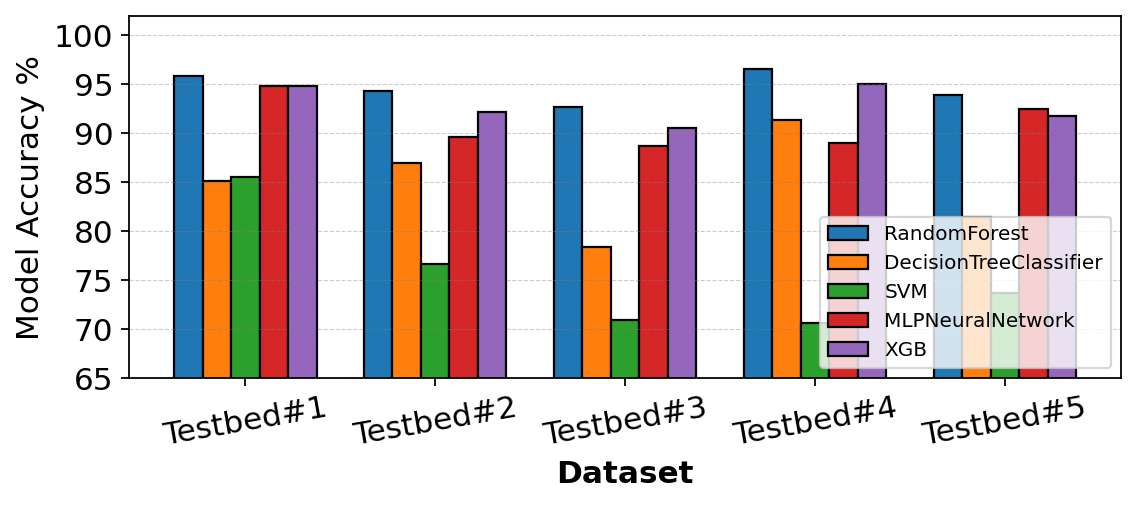

In [146]:
plt.rcParams.update({'font.size': 14})
# Figure Size
fig, ax = plt.subplots(figsize =(8, 3), dpi=160)
barWidth = 0.15

# Set position of bar on X axis
br1 = np.arange(len(datasets))
br2 = [x + barWidth for x in br1]
br3 = [x + barWidth for x in br2]
br4 = [x + barWidth for x in br3]
br5 = [x + barWidth for x in br4]

ax.grid(visible = True, axis='y', color ='grey', linestyle ='--', linewidth = 0.5, alpha = 0.4)
ax.set_ylabel('Model Accuracy %')
ax.set_ylim(ymin=65, ymax=102)


ax.bar(br1, all_accuracies['RandomForest'], width = barWidth, edgecolor ='black', label="RandomForest")
ax.bar(br2, all_accuracies['DecisionTreeClassifier'], width = barWidth, edgecolor ='black', label="DecisionTreeClassifier")
ax.bar(br3, all_accuracies['SVM'], width = barWidth, edgecolor ='black', label="SVM")
ax.bar(br4, all_accuracies['MLPNeuralNetwork'], width = barWidth, edgecolor ='black', label="MLPNeuralNetwork",)
ax.bar(br5, all_accuracies['XGB'], width = barWidth, edgecolor ='black', label="XGB")


plt.xlabel('Dataset', fontweight ='bold')
plt.yticks(np.arange(65, 101, 5))
xticks = ['Testbed#1', 'Testbed#2', 'Testbed#3', 'Testbed#4', 'Testbed#5']
plt.xticks([r + 0.3 for r in range(len(br1))], xticks, rotation=10)

plt.legend(fontsize = 9, loc='lower right')
plt.savefig("161_labels_accuracies.pdf", bbox_inches='tight')

## TEST WITH DIFFERENT CLASSIFIRES UNMERGED LEVELS - 5 labels


In [182]:
def grouped_to_5_cat(df, total_possible_labels):
    aggregated_labels = {}
    for i in range(total_possible_labels + 1):
        aggregated_labels[i] = i
    # 0 is normal and is one group itself
    # # group read together
    for i in range(1, 55):
        aggregated_labels.update({i: 1})

    # group write together
    for i in range(55, 109):
        aggregated_labels.update({i: 55})
    # group networks together
    for i in range(109, 145):
        aggregated_labels.update({i: 109})
    # group tcp configs together
    for i in range(145, 157):
        aggregated_labels.update({i: 145})
    # group with networks together
    for i in range(157, 161):
        aggregated_labels.update({i: 109})
    y = [aggregated_labels[int(i)] for i in df[df.columns[len(df.columns) - 1]].values]
    df["label_value"] = y
    return df

def update_labels_xgboost_5cat(df):
    updated_labels = {0:0, 1:1, 55:2, 109:3, 145:4}
    y = [updated_labels[int(i)] for i in df[df.columns[len(df.columns) - 1]].values]
    df["label_value"] = y
    return df


In [176]:
df = pd.read_csv(filenames.get('emulab_hdd_unmerged')).drop(['time_stamp', 'through_put'], axis=1)
df.shape
df = grouped_to_5_cat(df, 161)
print(df.shape)
print(len(dict(Counter(df[df.columns[len(df.columns) - 1]]))))

y = df.label_value
# X = df.drop(columns="label_value")[features_2] # df[features]
# X = df.drop(columns="label_value")[features] # df[features]
X = df.drop(columns="label_value") # df[features]
X_train, X_test, y_train, y_test = train_test_split(X,y)
# print(X_train.shape)
X_train, y_train = RandomUnderSampler(sampling_strategy="all").fit_resample(X_train, y_train)
print(X_train.shape)
clf = RandomForestClassifier(n_estimators=100)
# clf = make_pipeline(StandardScaler(), SVC())
# clf = SVC()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(np.round(metrics.accuracy_score(y_test, y_pred) * 100, 2))
score = np.round(clf.feature_importances_, 2)
# print(sorted(list(score), reverse=True))
print("Cummulative Importance Score: \n", np.cumsum(sorted(list(score), reverse=True)))
print(Counter(score))
features_3 = []
for i in range(len(score)):
    if score[i] >= 0.02:
        features_3.append(X.columns[i])
        # print(df.columns[i])
print(features_3)
print(len(features_3))

(41313, 117)
5
(955, 116)
90.6
Cummulative Importance Score: 
 [0.08 0.14 0.18 0.22 0.26 0.3  0.33 0.36 0.39 0.42 0.45 0.48 0.5  0.52
 0.54 0.56 0.58 0.6  0.62 0.64 0.66 0.68 0.69 0.7  0.71 0.72 0.73 0.74
 0.75 0.76 0.77 0.78 0.79 0.8  0.81 0.82 0.83 0.84 0.85 0.86 0.87 0.88
 0.89 0.9  0.91 0.92 0.93 0.94 0.95 0.96 0.97 0.98 0.99 1.   1.01 1.02
 1.03 1.03 1.03 1.03 1.03 1.03 1.03 1.03 1.03 1.03 1.03 1.03 1.03 1.03
 1.03 1.03 1.03 1.03 1.03 1.03 1.03 1.03 1.03 1.03 1.03 1.03 1.03 1.03
 1.03 1.03 1.03 1.03 1.03 1.03 1.03 1.03 1.03 1.03 1.03 1.03 1.03 1.03
 1.03 1.03 1.03 1.03 1.03 1.03 1.03 1.03 1.03 1.03 1.03 1.03 1.03 1.03
 1.03 1.03 1.03 1.03]
Counter({0.0: 59, 0.01: 35, 0.02: 10, 0.03: 6, 0.04: 4, 0.06: 1, 0.08: 1})
['sender_avg_rtt_value', 'sender_pacing_rate', 'sender_cwnd_rate', 'sender_retrans', 'sender_ssthresh_value', 'sender_segs_in', 'sender_avg_send_value', 'sender_unacked_value', 'sender_tcp_snd_buffer_min', 'sender_tcp_snd_buffer_max', 'sender_avg_waittime_md', 'sender_rem

In [183]:
features_3 = ['sender_avg_rtt_value', 'sender_pacing_rate', 'sender_cwnd_rate', 'sender_retrans', 'sender_ssthresh_value', 'sender_segs_in', 'sender_avg_send_value', 'sender_unacked_value', 'sender_tcp_snd_buffer_min', 'sender_tcp_snd_buffer_max', 'sender_avg_waittime_md', 'sender_remote_ost_read_bytes', 'sender_remote_ost_write_bytes', 'receiver_seg_out', 'receiver_segs_in', 'receiver_vsize', 'receiver_cpu_usage_percentage', 'receiver_write_bytes', 'receiver_avg_waittime_md', 'receiver_system_cpu_percent', 'receiver_remote_ost_read_bytes', 'receiver_remote_ost_write_bytes']

In [188]:
datasets = ['emulab_hdd_unmerged', 'utah_ssd_unmerged', 'wisconsin_ssd_unmerged', 'utah_ssd_unmerged_1g', 'wisconsin_hdd-ssd_unmerged']
classifiers = {"RandomForest": RandomForestClassifier(n_estimators=100),
           "DecisionTreeClassifier": DecisionTreeClassifier(),
           "SVM": svm.SVC(),
           "MLPNeuralNetwork": MLPClassifier(),
           "XGB": XGBClassifier(),
        }
classifiers_legends = list(classifiers.keys())
all_accuracies = {}
round_number = 5
for clf_key in classifiers:
    accuracies = np.zeros(len(classifiers_legends))
    for i in range(round_number):
        temp_acc = np.array([])
        for key in datasets:
            print("run {} model for dataset: {}".format(clf_key.replace("\n", " "), key))
            df = pd.read_csv(filenames.get(key)).drop(['time_stamp', 'through_put'], axis=1)
            df = grouped_to_5_cat(df, 161)
            if clf_key == "XGB":
                df = update_labels_xgboost_5cat(df)
            y = df.label_value
            X = df.drop(columns="label_value")[features_3]#[features] # df[features]
            X_train, X_test, y_train, y_test = train_test_split(X,y)
            # print(X_train.shape)
            X_train, y_train = RandomUnderSampler(sampling_strategy="all").fit_resample(X_train, y_train)
            # print(X_train.shape)
            # clf = classifiers[clf_key]
            clf = model_factory(clf_key)
            clf = make_pipeline(StandardScaler(), clf)
            clf.fit(X_train, y_train)
            y_pred = clf.predict(X_test)
            accuracy = np.round(metrics.accuracy_score(y_test, y_pred) * 100, 2)
            print(accuracy)
            temp_acc = np.append(temp_acc, accuracy)
        accuracies = np.add(accuracies, temp_acc)
    print("\n")
    accuracies = accuracies / round_number
    all_accuracies[clf_key] = accuracies

print(classifiers_legends)
print(datasets)
print(all_accuracies)

run RandomForest model for dataset: emulab_hdd_unmerged
90.98
run RandomForest model for dataset: utah_ssd_unmerged
97.43
run RandomForest model for dataset: wisconsin_ssd_unmerged
93.52
run RandomForest model for dataset: utah_ssd_unmerged_1g
98.31
run RandomForest model for dataset: wisconsin_hdd-ssd_unmerged
94.43
run RandomForest model for dataset: emulab_hdd_unmerged
90.73
run RandomForest model for dataset: utah_ssd_unmerged
97.57
run RandomForest model for dataset: wisconsin_ssd_unmerged
93.92
run RandomForest model for dataset: utah_ssd_unmerged_1g
99.15
run RandomForest model for dataset: wisconsin_hdd-ssd_unmerged
94.0
run RandomForest model for dataset: emulab_hdd_unmerged
90.87
run RandomForest model for dataset: utah_ssd_unmerged
98.38
run RandomForest model for dataset: wisconsin_ssd_unmerged
93.89
run RandomForest model for dataset: utah_ssd_unmerged_1g
99.02
run RandomForest model for dataset: wisconsin_hdd-ssd_unmerged
94.15
run RandomForest model for dataset: emulab_h

In [147]:
_5_labels_accs = all_accuracies
all_accuracies = {'RandomForest': np.array([91.504, 97.802, 93.992, 98.874, 93.98 ]), 'DecisionTreeClassifier': np.array([85.612, 95.338, 90.472, 99.164, 88.704]), 'SVM': np.array([77.786, 84.252, 77.776, 91.288, 83.964]), 'MLPNeuralNetwork': np.array([81.892, 89.792, 84.51 , 92.894, 88.966]), 'XGB': np.array([98.428, 98.894, 94.154, 98.99 , 94.798])}

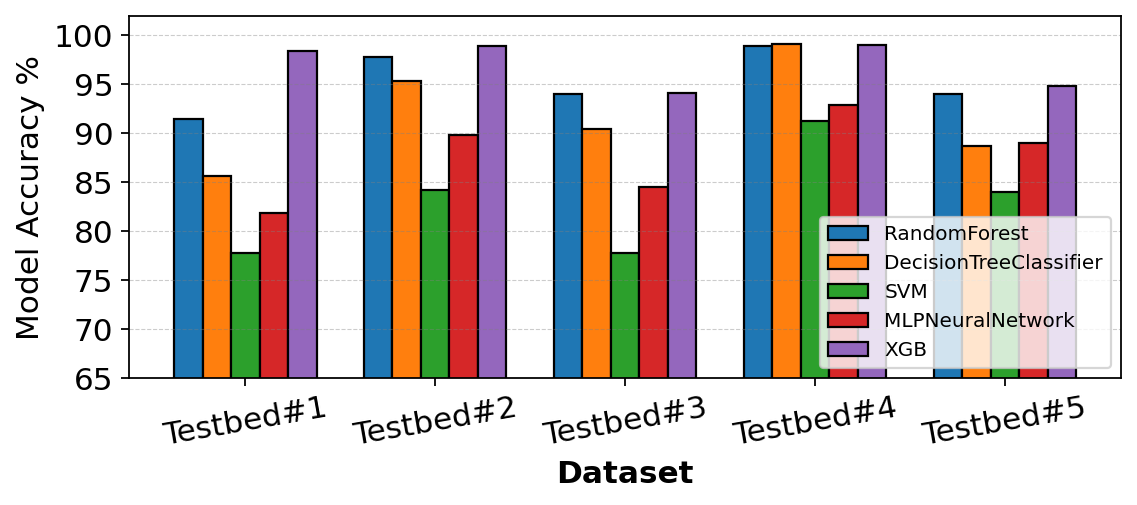

In [193]:
plt.rcParams.update({'font.size': 14})
# Figure Size
fig, ax = plt.subplots(figsize =(8, 3), dpi=160)
barWidth = 0.15

# Set position of bar on X axis
br1 = np.arange(len(datasets))
br2 = [x + barWidth for x in br1]
br3 = [x + barWidth for x in br2]
br4 = [x + barWidth for x in br3]
br5 = [x + barWidth for x in br4]

ax.grid(visible = True, axis='y', color ='grey', linestyle ='--', linewidth = 0.5, alpha = 0.4)
ax.set_ylabel('Model Accuracy %')
ax.set_ylim(ymin=70, ymax=102)


ax.bar(br1, all_accuracies['RandomForest'], width = barWidth, edgecolor ='black', label="RandomForest")
ax.bar(br2, all_accuracies['DecisionTreeClassifier'], width = barWidth, edgecolor ='black', label="DecisionTreeClassifier")
ax.bar(br3, all_accuracies['SVM'], width = barWidth, edgecolor ='black', label="SVM")
ax.bar(br4, all_accuracies['MLPNeuralNetwork'], width = barWidth, edgecolor ='black', label="MLPNeuralNetwork")
ax.bar(br5, all_accuracies['XGB'], width = barWidth, edgecolor ='black', label="XGB")


plt.xlabel('Dataset', fontweight ='bold')
plt.yticks(np.arange(65, 101, 5))
xticks = ['Testbed#1', 'Testbed#2', 'Testbed#3', 'Testbed#4', 'Testbed#5']
plt.xticks([r + 0.3 for r in range(len(br1))], xticks,  rotation=10)
plt.legend(fontsize = 9, loc='lower right')

plt.savefig("5_labels_accuracies.pdf", bbox_inches='tight')

## Overhead analysis

In [ ]:
sender_overhead = pd.read_csv("/Users/ehsan/Documents/phd/cloudLabLogs/overhead/sender/overhead_footprints.csv")
receiver_overhead = pd.read_csv("/Users/ehsan/Documents/phd/cloudLabLogs/overhead/receiver/overhead_footprints.csv")

In [8]:
sender_overhead.head(n=1)

,1651788228.2362200,0.048239946365356400,0,0.0,0.016891201284861200
0,1.651788e+09,0.044028,4084,5.9,0.017113


In [9]:
# Counter(receiver_overhead.iloc[:, 3])
# np.nanstd(receiver_overhead.iloc[:, 3])
np.mean(sender_overhead.iloc[1:, 1])

0.04517000447148862

In [10]:
CPU_footprints = np.array([])
CPU_std = np.array([])

Mem_footprints = np.array([])
Mem_std = np.array([])

collection_time = np.array([])
collection_time_std = np.array([])

payload_size = np.array([])
payload_size_std = np.array([])

collection_time = np.append(collection_time, np.mean(sender_overhead.iloc[1:, 1]))
collection_time_std = np.append(collection_time_std, np.nanstd(sender_overhead.iloc[1:, 1]))
collection_time = np.append(collection_time, np.mean(receiver_overhead.iloc[1:, 1]))
collection_time_std = np.append(collection_time_std, np.nanstd(receiver_overhead.iloc[1:, 1]))

payload_size = np.append(payload_size, np.mean(sender_overhead.iloc[1:, 2]))
payload_size_std = np.append(payload_size_std, np.nanstd(sender_overhead.iloc[1:, 2]))
payload_size = np.append(payload_size, np.mean(receiver_overhead.iloc[1:, 2]))
payload_size_std = np.append(payload_size_std, np.nanstd(receiver_overhead.iloc[1:, 2]))

CPU_footprints = np.append(CPU_footprints, np.mean(sender_overhead.iloc[1:, 3]))
CPU_std = np.append(CPU_std, np.nanstd(sender_overhead.iloc[1:, 3]))
CPU_footprints = np.append(CPU_footprints, np.mean(receiver_overhead.iloc[1:, 3]))
CPU_std = np.append(CPU_std, np.nanstd(receiver_overhead.iloc[1:, 3]))


Mem_footprints = np.append(Mem_footprints, np.mean(sender_overhead.iloc[1:, 4]))
Mem_std = np.append(Mem_std, np.nanstd(sender_overhead.iloc[1:, 4]))
Mem_footprints = np.append(Mem_footprints, np.mean(receiver_overhead.iloc[1:, 4]))
Mem_std = np.append(Mem_std, np.nanstd(receiver_overhead.iloc[1:, 4]))

data = np.array([CPU_footprints, Mem_footprints, collection_time, payload_size])
print(data)

[[1.74782609e+00 1.94067797e+00]
 [1.70680859e-02 1.71337074e-02]
 [4.51700045e-02 5.05474159e-02]
 [4.07264348e+03 4.31992373e+03]]


In [13]:
print(np.mean(data[0]))
print(np.mean(data[1]))
print(np.mean(data[2]))
print(np.mean(data[3]))

1.8442520265291082
0.017100896642522963
0.04785871019939682
4196.283603537215


Text(0, 0.5, 'Ave.  payload size (bytes)')

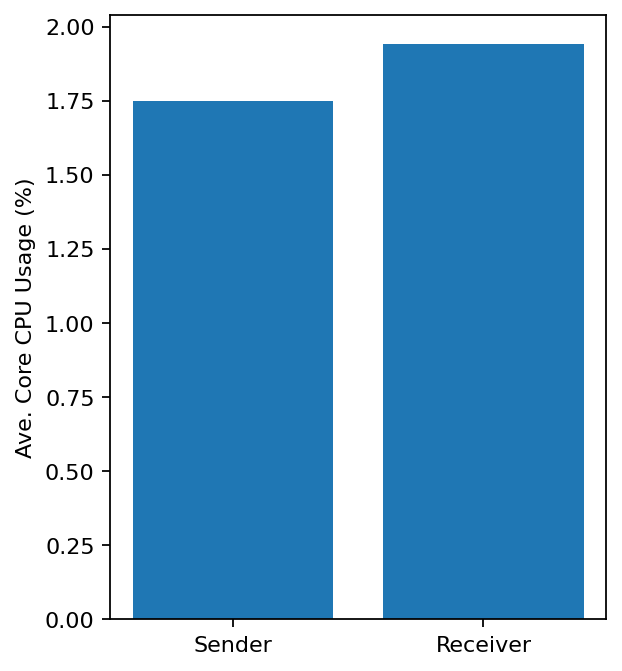

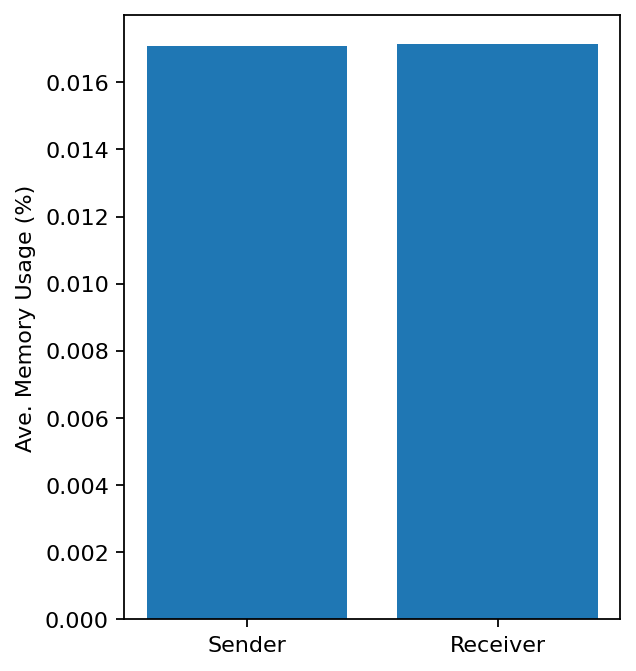

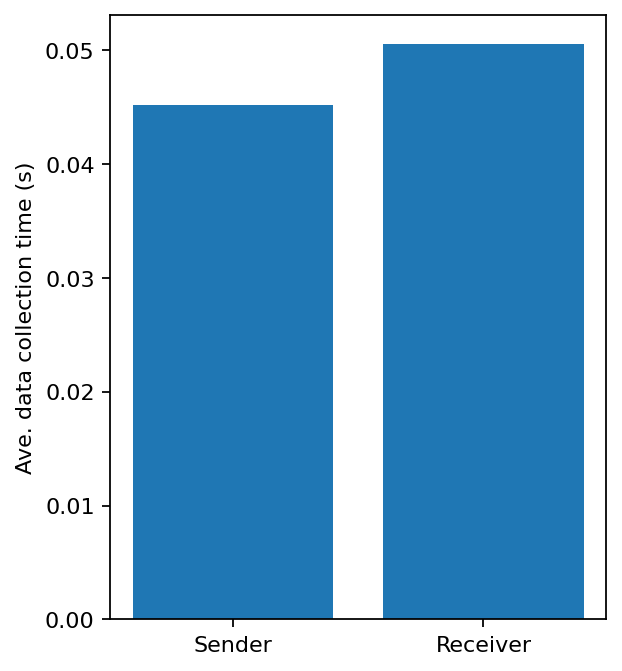

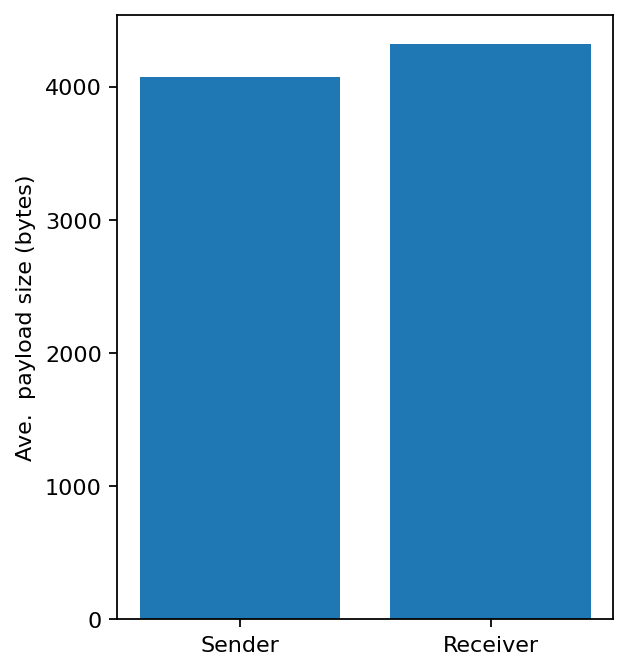

In [11]:
plt.rcParams.update({'font.size': 18})

fig, ax = plt.subplots(figsize =(4, 5), dpi=160)
# fig.suptitle('Monitoring agent\'s Resource Usage footprints')
ax.bar(['Sender', 'Receiver'], data[0], label='Core CPU Usage (%)')
ax.set_ylabel('Ave. Core CPU Usage (%)')
# ax.set_xlabel('Transfer Side')

fig2, ax2 = plt.subplots(figsize =(4, 5), dpi=160)
ax2.bar(['Sender', 'Receiver'], data[1], label='Memory Usage (%)')
ax2.set_ylabel('Ave. Memory Usage (%)')
# ax2.set_xlabel('Transfer Side')

fig3, ax3 = plt.subplots(figsize =(4, 5), dpi=160)
ax3.bar(['Sender', 'Receiver'], data[2], label='Time (s)')
ax3.set_ylabel('Ave. data collection time (s)')
# ax3.set_xlabel('Transfer Side')

fig4, ax4 = plt.subplots(figsize =(4, 5), dpi=160)
ax4.bar(['Sender', 'Receiver'], data[3], label='Size (bytes)')
ax4.set_ylabel('Ave.  payload size (bytes)')

# plt.show()

## Transfer Learning


In [103]:
filenames_merged = {
    "emulab_hdd_merged": "emulab_d460_10Gbps_hdd_merged_V2.csv",
    # "emulab_hdd_unmerged": "emulab_d460_10Gbps_hdd_unmerged_V2.csv",

    "utah_ssd_merged": "utah_c6525-25g_25Gbps_ssd_merged_V2.csv",
    # "utah_ssd_unmerged": "utah_c6525-25g_25Gbps_ssd_unmerged_V2.csv",

    "wisconsin_ssd_merged": "wisconsin_c220g1-10Gbps_ssd_merged_V2.csv",
    # "wisconsin_ssd_unmerged": "wisconsin_c220g1-10Gbps_ssd_unmerged_V2.csv",

    "utah_ssd_merged_1g": "utah_c6525-25g_1Gbps_ssd_merged_V2.csv",
    # "utah_ssd_unmerged_1g": "utah_c6525-25g_1Gbps_ssd_unmerged_V2.csv",

    "wisconsin_hdd_ssd_merged": "wisconsin_c220g1-10Gbps_hdd_ssd_merged_V2.csv",
    # "wisconsin_hdd-ssd_unmerged": "wisconsin_c220g1-10Gbps_hdd_ssd_unmerged_V2.csv",
}
data = {}

In [104]:


def read_file(transform=False):
    global data, filenames_merged

    for key in filenames_merged:
        df = pd.read_csv(filenames[key])
        df = df.sort_values(by=['label_value']).reset_index().drop(['index','time_stamp', 'through_put'], axis=1)
        df.fillna(df.groupby(['label_value'], as_index=False).mean(), inplace=True)

        if transform:
            for index, row in features.iterrows():
                df[row['feature']] = df[row['feature']] / df[row['normalizer']]

        df.replace([np.inf, -np.inf, np.nan], 0, inplace=True)
        data[key] = df

read_file()

In [75]:
feature_list = features
for key in data:
    df = data[key].copy()
    y = df.label_value
    X = df[feature_list]
    clf = make_pipeline(StandardScaler(),  RandomForestClassifier(n_estimators=100)) #RandomForestClassifier(n_estimators=100)
    cv_res = np.round(cross_val_score(clf, X, y, cv=10, scoring="f1_weighted"),4)
    print(f'{key} ==>{cv_res}')
    print(f'{key} ==> mean: {np.round(np.mean(cv_res)*100, 2)}, std: {np.round(np.std(cv_res)*100, 2)}')

emulab_hdd_merged ==>[0.9761 0.9788 0.967  0.9775 0.987  0.9869 0.9816 0.9804 0.9835 0.955 ]
emulab_hdd_merged ==> mean: 97.74, std: 0.93
utah_ssd_merged ==>[0.9997 0.9993 0.9962 0.9938 0.9906 0.9976 0.9993 0.9993 0.9993 0.9983]
utah_ssd_merged ==> mean: 99.73, std: 0.28
wisconsin_ssd_merged ==>[0.9838 0.9975 0.9947 0.9591 0.9786 0.9904 0.9901 0.9925 0.987  0.986 ]
wisconsin_ssd_merged ==> mean: 98.6, std: 1.03
utah_ssd_merged_1g ==>[0.9889 0.9977 0.9977 0.9956 0.9909 0.9935 0.9969 0.9873 0.9975 0.998 ]
utah_ssd_merged_1g ==> mean: 99.44, std: 0.38
wisconsin_hdd_ssd_merged ==>[0.9833 0.9922 0.986  0.9823 0.9877 0.9774 0.9854 0.9893 0.9864 0.9886]
wisconsin_hdd_ssd_merged ==> mean: 98.59, std: 0.39


In [120]:
transfer_learning_acc = []

for key1 in data:
    df = data[key1].copy()
    y = df.label_value
    X = df[feature_list]#[feature_list] #.drop(columns="label_value")
    X_train, X_test, y_train, y_test = train_test_split(X,y)
    X_train, y_train = RandomUnderSampler(sampling_strategy="all").fit_resample(X_train, y_train)

    clf = RandomForestClassifier(n_estimators=100)
    clf.fit(X_train, y_train)
    acc = np.array([])
    for key2 in data:
        # if key1 == key2:
        #     continueK

        df_test = data[key2].copy()
        y_test = df_test.label_value
        X_test = df_test[feature_list]#.drop(columns="label_value")

        y_pred = clf.predict(X_test)
        np.round(metrics.accuracy_score(y_test, y_pred) * 100, 2)
        print(f"{key1} ==> {key2} - {np.round(metrics.f1_score(y_test, y_pred, average='weighted') * 100, 2)}")
        acc = np.append(acc, np.round(metrics.f1_score(y_test, y_pred, average='weighted') * 100, 2))
    transfer_learning_acc.append(acc)
    print("\n")
transfer_learning_acc = np.array(transfer_learning_acc)

emulab_hdd_merged ==> emulab_hdd_merged - 95.71
emulab_hdd_merged ==> utah_ssd_merged - 36.6
emulab_hdd_merged ==> wisconsin_ssd_merged - 29.71
emulab_hdd_merged ==> utah_ssd_merged_1g - 39.33
emulab_hdd_merged ==> wisconsin_hdd_ssd_merged - 45.11


utah_ssd_merged ==> emulab_hdd_merged - 51.92
utah_ssd_merged ==> utah_ssd_merged - 99.28
utah_ssd_merged ==> wisconsin_ssd_merged - 58.25
utah_ssd_merged ==> utah_ssd_merged_1g - 41.28
utah_ssd_merged ==> wisconsin_hdd_ssd_merged - 56.82


wisconsin_ssd_merged ==> emulab_hdd_merged - 46.16
wisconsin_ssd_merged ==> utah_ssd_merged - 77.86
wisconsin_ssd_merged ==> wisconsin_ssd_merged - 97.5
wisconsin_ssd_merged ==> utah_ssd_merged_1g - 43.79
wisconsin_ssd_merged ==> wisconsin_hdd_ssd_merged - 55.46


utah_ssd_merged_1g ==> emulab_hdd_merged - 27.43
utah_ssd_merged_1g ==> utah_ssd_merged - 34.55
utah_ssd_merged_1g ==> wisconsin_ssd_merged - 31.68
utah_ssd_merged_1g ==> utah_ssd_merged_1g - 99.01
utah_ssd_merged_1g ==> wisconsin_hdd_ssd_merge

[Text(0, 0.5, 'Tb #1'),
 Text(0, 1.5, 'Tb #2'),
 Text(0, 2.5, 'Tb #3'),
 Text(0, 3.5, 'Tb #4'),
 Text(0, 4.5, 'Tb #5')]

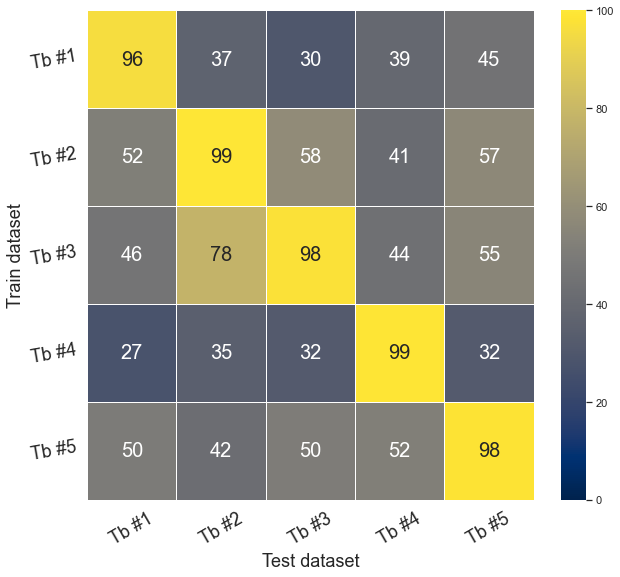

In [166]:
sns.set(rc={'figure.figsize':(10,9), 'font.size': 20})

ax = sns.heatmap(transfer_learning_acc, annot=True,  vmin=0, vmax=100, cmap="cividis",linewidths=.5)
ax.set_xlabel('Test dataset', fontsize= 18)
ax.set_ylabel('Train dataset', fontsize= 18)
ticks_labels = ["Tb #1", "Tb #2", "Tb #3", "Tb #4", "Tb #5"]
ax.set_xticklabels(ticks_labels, rotation=30, fontsize= 18)
ax.set_yticklabels(ticks_labels, rotation=10, fontsize= 18)

## RUN with montage application

In [49]:
wisconsin_ssd_merged = pd.read_csv(filenames.get('wisconsin_ssd_merged')).drop(['time_stamp', 'through_put'], axis=1)

# montage_df = pd.read_csv("normal.csv").drop(['time_stamp', 'through_put'], axis=1)
# wisconsin_ssd_merged = wisconsin_ssd_merged.append(montage_df, ignore_index=True)

df = wisconsin_ssd_merged

y = df.label_value
X = df.drop(columns="label_value")[features] # df[features]
X_train, X_test, y_train, y_test = train_test_split(X,y)
print(X_train.shape)
X_train, y_train = RandomUnderSampler(sampling_strategy="all").fit_resample(X_train, y_train)
print(X_train.shape)
clf = RandomForestClassifier(n_estimators=100)
# clf = make_pipeline(StandardScaler(), clf)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(np.round(metrics.accuracy_score(y_test, y_pred) * 100, 2))
# print(metrics.confusion_matrix(y_test, y_pred))

(18156, 24)
(2331, 24)
97.47


In [33]:
normal = df.loc[df['label_value'] == 0]
y_pred = clf.predict(normal.drop(columns="label_value")[features])
# y_pred = clf.predict(normal.drop(columns="label_value"))
print(Counter(y_pred))

Counter({0: 141, 10: 2})


In [296]:
normal

,sender_avg_rtt_value,sender_pacing_rate,sender_cwnd_rate,sender_avg_retransmission_timeout_value,sender_byte_ack,sender_seg_out,sender_retrans,sender_ssthresh_value,sender_segs_in,sender_avg_send_value,...,receiver_setattr_md,receiver_read_page_md,receiver_unlink_md,receiver_avg_dsack_dups_value,receiver_avg_reord_seen,receiver_system_cpu_percent,receiver_system_memory_percent,receiver_remote_ost_read_bytes,receiver_remote_ost_write_bytes,label_value
9005,0.329,0.0,591.0,201.0,526.314484,381531.0,0.0,548.0,3560.0,20808.9,...,0,0,0,0.0,0.0,4.1,1.6,0,549453072,0
9006,0.486,30502.1,641.0,201.0,523.164070,379582.0,0.0,548.0,3164.0,15278.5,...,0,0,0,0.0,0.0,4.5,1.7,0,532676608,0
9007,0.263,30502.1,659.0,201.0,525.744080,380493.0,0.0,548.0,3401.0,29026.1,...,0,0,0,0.0,0.0,4.5,1.7,0,528482304,0
9008,0.319,30502.1,667.0,201.0,521.473427,378001.0,0.0,548.0,3147.0,24221.1,...,0,0,0,0.0,0.0,4.4,1.8,0,528482304,0
9009,5.324,2071.3,476.0,206.0,368.986862,267381.0,1.0,474.0,2275.0,1035.7,...,1,0,0,0.0,0.0,3.7,1.9,0,494927872,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9143,0.402,23871.2,637.0,201.0,522.140564,378315.0,0.0,478.0,3600.0,18355.7,...,0,0,0,0.0,0.0,4.5,2.4,0,465567744,0
9144,0.368,23871.2,657.0,201.0,522.481987,378360.0,0.0,478.0,3406.0,20681.2,...,0,0,0,0.0,0.0,4.5,2.4,0,478150656,0
9145,0.313,23871.2,677.0,201.0,521.331459,377743.0,0.0,478.0,3178.0,25055.5,...,0,0,0,0.0,0.0,4.0,2.5,0,419430400,0
9146,0.271,23871.2,691.0,201.0,448.237671,324729.0,0.0,478.0,2943.0,29537.1,...,1,0,0,0.0,0.0,3.9,2.5,0,411041792,0


In [41]:
# montage_df = pd.read_csv("normal.csv").drop(['time_stamp', 'through_put'], axis=1)
montage_df = pd.read_csv("./montage_analysis/montage_5_instance.csv").drop(['time_stamp', 'through_put'], axis=1)
# montage_df = montage_df.iloc[49:56]
# montage_df['sender_remote_ost_write_bytes']
montage_df_write_part = montage_df.loc[(montage_df['sender_remote_ost_write_bytes'] > 0)]
montage_df_write_part

,sender_avg_rtt_value,sender_pacing_rate,sender_cwnd_rate,sender_avg_retransmission_timeout_value,sender_byte_ack,sender_seg_out,sender_retrans,sender_ssthresh_value,sender_segs_in,sender_avg_send_value,...,receiver_setattr_md,receiver_read_page_md,receiver_unlink_md,receiver_avg_dsack_dups_value,receiver_avg_reord_seen,receiver_system_cpu_percent,receiver_system_memory_percent,receiver_remote_ost_read_bytes,receiver_remote_ost_write_bytes,label_value
1,0.395,24017.4,410.0,201.0,530.100227,384440.0,9.0,301.0,3584.0,12023.9,...,0,0,0,0.0,0.0,4.5,1.9,0,541065216,1002
2,0.371,32729.8,525.0,201.0,448.398399,324972.0,0.0,301.0,2762.0,16392.5,...,0,0,0,0.0,0.0,4.2,1.9,0,499122176,1002
3,0.303,32729.8,557.0,201.0,397.631310,288495.0,0.0,301.0,2323.0,21294.7,...,0,0,0,0.0,0.0,3.6,1.9,0,423624704,1002
9,0.356,22057.3,720.0,201.0,511.331978,370595.0,0.0,301.0,3323.0,23428.3,...,0,0,0,0.0,0.0,4.5,2.3,0,473956352,1002
10,0.314,22057.3,742.0,201.0,501.009460,363361.0,0.0,301.0,3187.0,27373.7,...,0,0,0,0.0,0.0,4.4,2.4,0,465567744,1002
11,0.366,22057.3,755.0,201.0,495.391594,359265.0,0.0,301.0,3417.0,23896.0,...,0,0,0,0.0,0.0,4.5,2.4,0,419430400,1002
26,0.359,29095.9,747.0,201.0,520.916954,377726.0,0.0,583.0,3024.0,24103.8,...,0,0,0,0.0,0.0,4.0,3.2,0,461373440,1002
29,0.384,29095.9,753.0,201.0,432.919235,313557.0,0.0,583.0,3428.0,22715.5,...,0,0,0,0.0,0.0,3.2,3.4,0,452984832,1002
30,0.329,29095.9,753.0,201.0,413.758461,299816.0,0.0,583.0,3307.0,26512.9,...,0,0,0,0.0,0.0,3.4,3.4,0,444596224,1002
31,0.426,29095.9,765.0,201.0,333.842384,242750.0,405.0,583.0,2080.0,20802.3,...,0,0,0,0.0,0.0,4.2,3.4,0,465567744,1002


In [50]:
montage_X = montage_df_write_part.drop(columns="label_value")[features]
# y_pred = clf.predict(normal.drop(columns="label_value"))
y_pred = clf.predict(montage_X)
print(Counter(y_pred))
# len(y_pred)
# print(30/102)

Counter({64: 47, 46: 3, 0: 2, 10: 1})


In [51]:
y_pred == 64

array([ True,  True,  True, False,  True,  True, False, False,  True,
        True,  True, False,  True,  True, False,  True,  True,  True,
       False,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True])

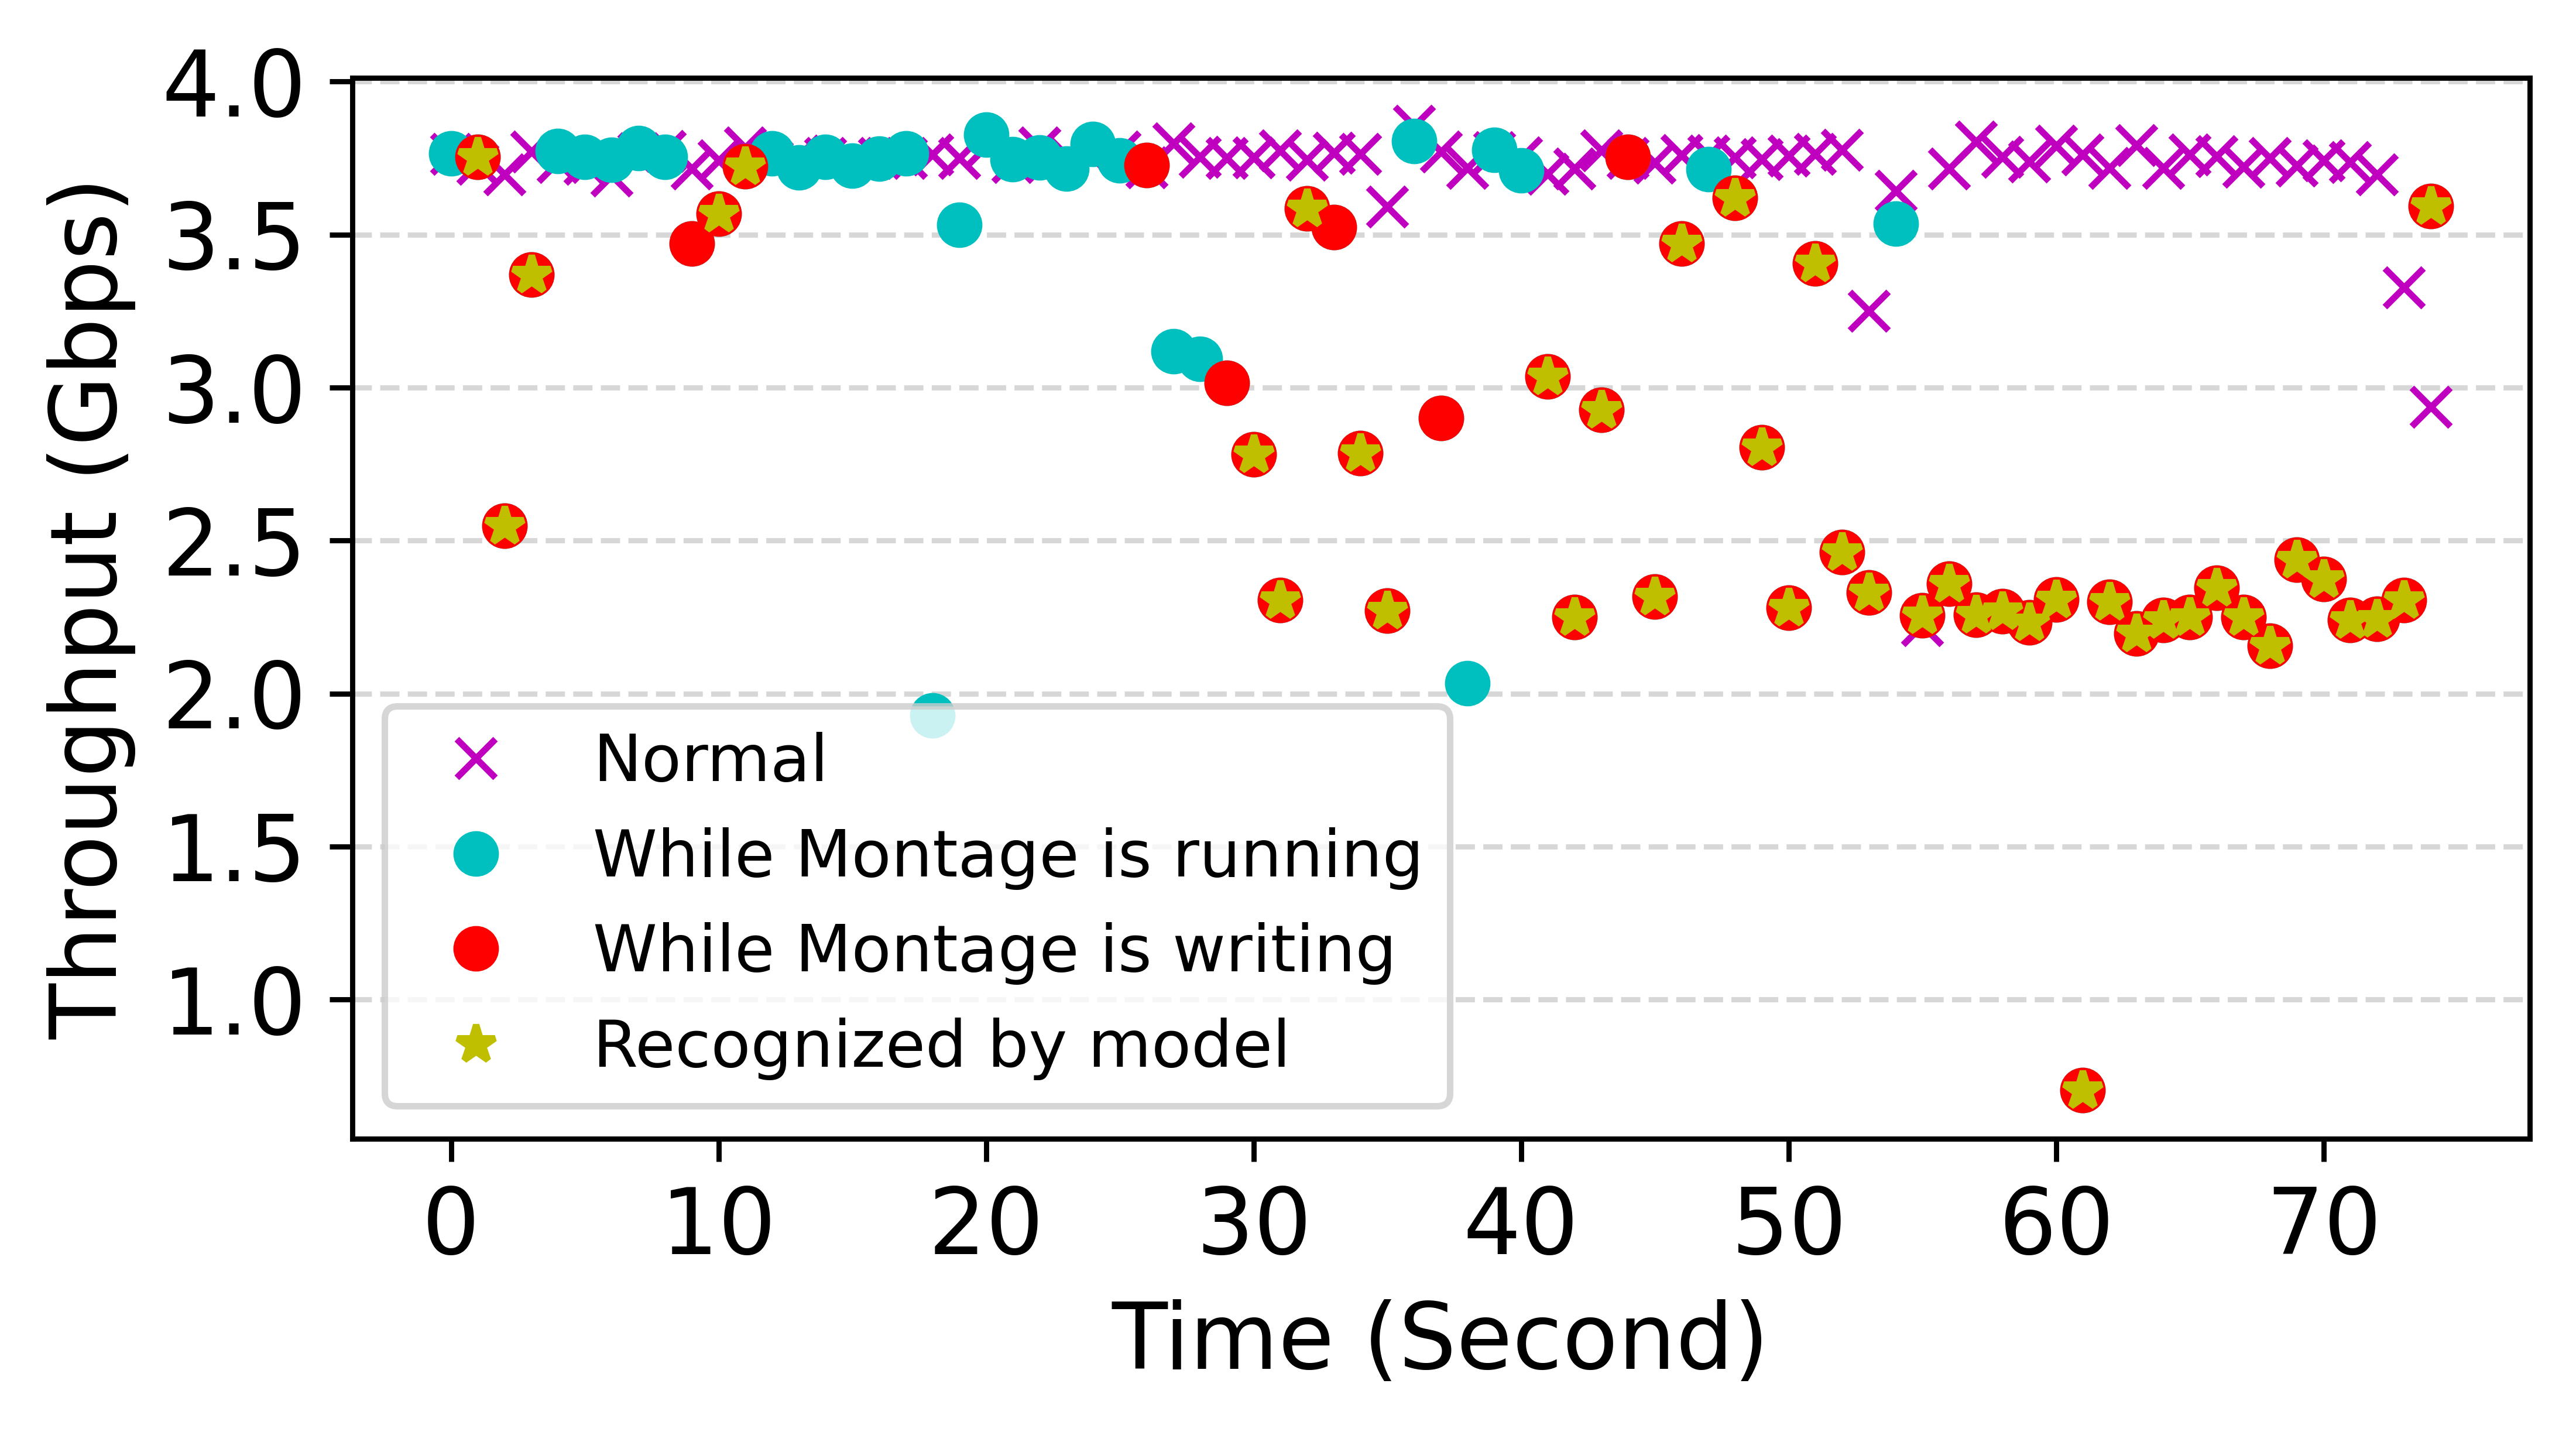

In [84]:
montage_1_df = pd.read_csv("./montage_analysis/montage_1_instance.csv")
montage_5_df = pd.read_csv("./montage_analysis/montage_5_instance.csv")
normal_df = pd.read_csv("./montage_analysis/normal.csv")
rows = montage_df.shape[0]


from matplotlib.pyplot import figure
from matplotlib import pyplot as plt
plt.rcParams.update({'font.size': 14})

fig, ax = plt.subplots(figsize =(6, 3), dpi=800)
# fig.suptitle('Monitoring agent\'s Resource Usage footprints')
ax.set_xticks(np.arange(0, montage_1_df.shape[0] , 10))
ax.set_yticks(np.arange(0, 4.5, 0.5))
ax.set_ylabel('Throughput (Gbps)')
ax.set_xlabel('Time (Second)')
x_range = np.arange(0, 75 , 1)
# ax.plot(np.arange(0, normal_df.shape[0]  , 1), montage_df.iloc[:normal_df.shape[0],:]['through_put'])
# ax.plot(np.arange(0, 75  , 1), montage_1_df.iloc[:75]['through_put'], 'x')
ax.plot(x_range, normal_df['through_put'], 'mx', label="Normal")
ax.plot(x_range, montage_5_df.iloc[:75]['through_put'], 'co', label="While Montage is running")

real_writes_x = montage_5_df.loc[(montage_5_df['sender_remote_ost_write_bytes'] > 0)].index
real_writes_y = montage_5_df.loc[(montage_5_df['sender_remote_ost_write_bytes'] > 0)]
ax.plot(real_writes_x[real_writes_x < 75], real_writes_y.iloc[real_writes_x < 75]['through_put'], 'ro',label="While Montage is writing")

ax.plot(real_writes_x[np.logical_and(y_pred == 64, real_writes_x < 75)], real_writes_y.iloc[np.logical_and(y_pred == 64, real_writes_x < 75)]['through_put'], 'y*',linewidth=0.5, label="Recognized by model" )


ax.grid(True,which='both', axis='y', linestyle='--', alpha=0.5)
plt.legend(framealpha=0.8, loc='lower left', prop={"size":10})
# ax.xaxis.grid()
# ax.grid(axis='x',linestyle='--')
# plt.savefig("Real_world_montage.pdf", bbox_inches='tight')


[ True  True  True False  True  True False False  True  True  True False
  True  True False  True  True  True False  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True]
[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True False
 False False False False False]


array([ True,  True,  True, False,  True,  True, False, False,  True,
        True,  True, False,  True,  True, False,  True,  True,  True,
       False,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True, False, False, False, False, False, False])

In [99]:
montage_5_df['sender_remote_ost_write_bytes'] > 0

0     False
1      True
2      True
3      True
4     False
      ...  
85    False
86    False
87    False
88    False
89     True
Name: sender_remote_ost_write_bytes, Length: 90, dtype: bool

In [100]:
montage_5_df.loc[(montage_5_df['sender_remote_ost_write_bytes'] > 0)].index

Int64Index([ 1,  2,  3,  9, 10, 11, 26, 29, 30, 31, 32, 33, 34, 35, 37, 41, 42,
            43, 44, 45, 46, 48, 49, 50, 51, 52, 53, 55, 56, 57, 58, 59, 60, 61,
            62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 76, 77, 78, 81,
            84, 89],
           dtype='int64')